# Step 1 - Setup your environment

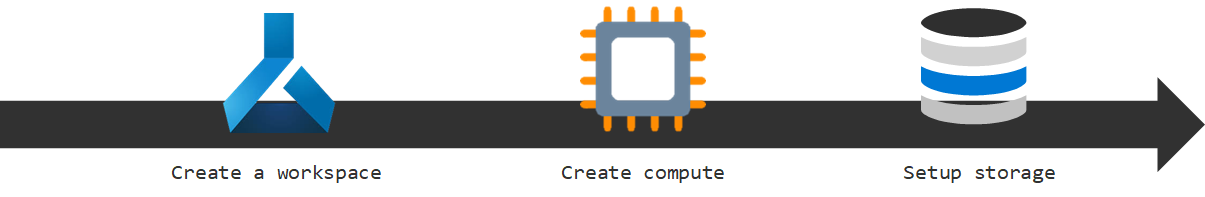

### 1) Clone C-3-Framework

In [ ]:
!git clone https://github.com/gjy3035/C-3-Framework.git

### 2) Upload Dataset to Datastore

In [ ]:
import azureml
from azureml.core import Workspace, Datastore, Experiment, Environment, Model
from azureml.core.resource_configuration import ResourceConfiguration
import urllib.request
from pathlib import Path

In [ ]:
# This will open an device login prompt. Login with your credentials that have access to the workspace.
# Connect to the workspace
ws = Workspace.from_config()
print("Using workspace:",ws.name,"in region", ws.location)

# Connect to the default datastore
ds = ws.get_default_datastore()
print("Datastore:",ds.name)

In [ ]:
# Create dataset directory
Path("dataset").mkdir(parents=True, exist_ok=True)

#### Download processed datasets from the preperation section of https://github.com/gjy3035/C-3-Framework and upload them them into the newly created dataset folder 

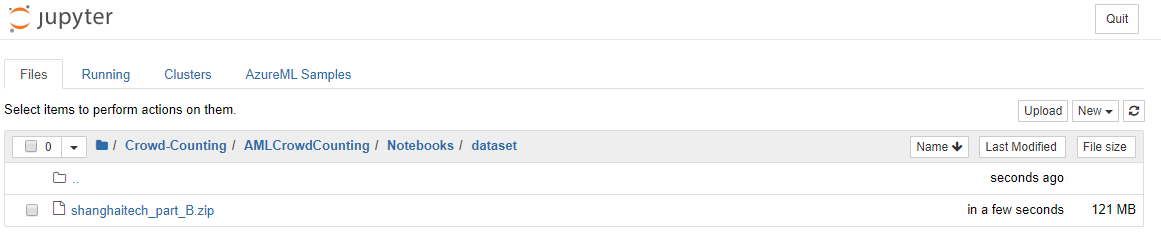


In [ ]:
# Upload data to the data store
ds.upload('dataset', target_path='cc_data/SHHB', overwrite=False, show_progress=True)

### 3) Setup Training Compute Cluster

In [ ]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

cluster_name = "cc-cluster"

try:
    cluster = ComputeTarget(workspace=ws, name=cluster_name)
    print('Using compute cluster:', cluster_name)
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC12',
                                                           vm_priority='lowpriority',
                                                           min_nodes=0,
                                                           max_nodes=1)
    cluster = ComputeTarget.create(ws, cluster_name, compute_config)
    cluster.wait_for_completion(show_output=True)

# Step 2 - Create and Run Training Experiment with your data 
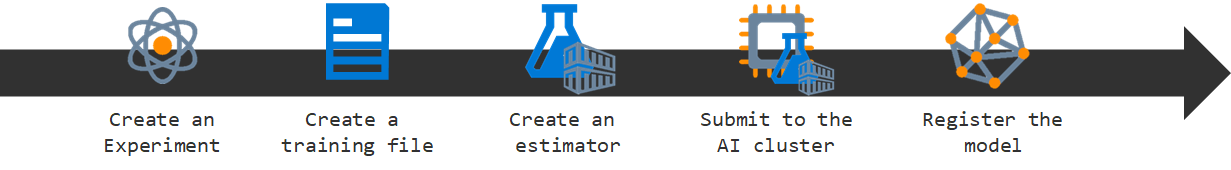

### 1) Create CC Train File

This is the script that is used to train a crowd counting model for this demo we will be training a MCNN Model on the Shanghai Tech Part B Dataset but this can be configured for any of the availble datasets and pull requests are welcome.

In [ ]:
%%writefile C-3-Framework/train.py

import os
import argparse
import shutil
import numpy as np
import torch
from torch import optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
from models.CC import CrowdCounter
from misc.utils import *
from config import cfg

from trainer import Trainer
# Prepare Trainer for AzureML by overide utils logger with Azure logger TDB
def logger(exp_path, exp_name, work_dir, exception, resume=False):
    from tensorboardX import SummaryWriter
    if not os.path.exists(exp_path):
        os.mkdir(exp_path)
    writer = SummaryWriter(exp_path+ '/' + exp_name)
    log_file = exp_path + '/' + exp_name + '/' + exp_name + '.txt'

    return writer, log_file

class AzureMLTrainer(Trainer):

    def __init__(self, dataloader, cfg_data, pwd):
        self.cfg_data = cfg_data

        self.data_mode = cfg.DATASET
        self.exp_name = cfg.EXP_NAME
        self.exp_path = cfg.EXP_PATH
        self.pwd = pwd

        self.net_name = cfg.NET
        self.net = CrowdCounter(cfg.GPU_ID,self.net_name).cuda()
        self.optimizer = optim.Adam(self.net.CCN.parameters(), lr=cfg.LR, weight_decay=1e-4)
        # self.optimizer = optim.SGD(self.net.parameters(), cfg.LR, momentum=0.95,weight_decay=5e-4)
        self.scheduler = StepLR(self.optimizer, step_size=cfg.NUM_EPOCH_LR_DECAY, gamma=cfg.LR_DECAY)          

        self.train_record = {'best_mae': 1e20, 'best_mse':1e20, 'best_model_name': ''}
        self.timer = {'iter time' : Timer(),'train time' : Timer(),'val time' : Timer()} 

        self.epoch = 0
        self.i_tb = 0
        
        if cfg.PRE_GCC:
            self.net.load_state_dict(torch.load(cfg.PRE_GCC_MODEL))

        self.train_loader, self.val_loader, self.restore_transform = dataloader()

        self.writer, self.log_txt = logger(self.exp_path, self.exp_name, self.pwd, 'exp', resume=cfg.RESUME)
        
#------------Process Inputs------------
parser = argparse.ArgumentParser(description='MCNN Trainer')
parser.add_argument('--data_folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--max_epoch', type=int, default=100, help='number of epochs to train')

args = parser.parse_args()

cfg.DATASET = 'SHHB'
cfg.NET = 'MCNN'
cfg.MAX_EPOCH = args.max_epoch

#------------Prepare Data------------
SHHB_PATH = os.path.join(args.data_folder, 'cc_data/{}'.format(cfg.DATASET))
if not os.path.isdir(os.path.join(SHHB_PATH,'train')):
    from zipfile import ZipFile
    # Create a ZipFile Object and load sample.zip in it
    with ZipFile(os.path.join(SHHB_PATH,'shanghaitech_part_B.zip'), 'r') as zipObj:
        zipObj.extractall(SHHB_PATH)
        os.rename(os.path.join(SHHB_PATH,'train_data'), os.path.join(SHHB_PATH,'train'))
        os.rename(os.path.join(SHHB_PATH,'test_data'), os.path.join(SHHB_PATH,'test'))
os.path.abspath('')
os.path.split(os.path.realpath(os.path.abspath('')))

#------------Start Training------------
from datasets.SHHB.loading_data import loading_data 
from datasets.SHHB.setting import cfg_data 
cfg_data.DATA_PATH = SHHB_PATH
pwd = os.path.split(os.path.realpath(os.path.abspath('')))[0]
cc_trainer = AzureMLTrainer(loading_data,cfg_data,pwd)
cc_trainer.forward()

#------------Copy Model Output------------        
mcnn_model = shutil.copytree(os.path.join(cfg.EXP_PATH, cfg.EXP_NAME), './outputs/exp')

### 2) Create an Experiment

In [ ]:
# Create an experiment or connect if it exists
from azureml.train.estimator import Estimator
experiment_name = "cc_MCNN"
exp = Experiment(workspace=ws, name=experiment_name)

### 3) Create and Run an Estimator


In [ ]:
script_params = {
    '--data_folder': ds,
}

cc_est = Estimator(source_directory='./C-3-Framework',
                   script_params=script_params,
                   compute_target=cluster,
                   use_gpu=True,
                   entry_script='train.py',
                   pip_packages=['torch',
                                 'torchvision',
                                 'tensorboardX',
                                 'tensorboard',
                                 'tensorflow',
                                 'easydict',
                                 'pandas',
                                 'numpy',
                                 'scipy'])

In [ ]:
run = exp.submit(cc_est)

In [ ]:
# Select a previous run
run = [r for r in exp.get_runs() if r.id == 'cc_MCNN_1583914876_137247d1'][0]

In [ ]:
from azureml.widgets import RunDetails
RunDetails(run).show()

### 4) Register Model

In [ ]:
model = run.register_model(model_name = 'MCNN-CrowdCounting-Model', 
                     model_path = 'outputs/exp/all_ep_99_mae_43.1_mse_68.0.pth', 
                     model_framework =  Model.Framework.CUSTOM,
                     description = 'MCNN Crowd Counting Model',
                     tags={'area': 'CV', 'type': 'MCNN', 'model_author': "C-3-Framework"},
                     resource_configuration = ResourceConfiguration(cpu=1, gpu=1, memory_in_gb=2))

print('version:', model.version)

# Step 3 Test Locally (Requires GPU)
If you don't have a machine with a GPU you can use an [AzureML Compute Instance](https://docs.microsoft.com/en-us/azure/machine-learning/concept-compute-instance)

In [ ]:
Path("./temp").mkdir(parents=True, exist_ok=True)
model.download(exist_ok=True,target_dir="./temp")

In [ ]:
from matplotlib import pyplot as plt
import matplotlib
import random
import torch
import sys
sys.path.insert(0, './C-3-Framework')
from torch.autograd import Variable
import torchvision.transforms as standard_transforms
import misc.transforms as own_transforms
import pandas as pd

from models.CC import CrowdCounter
from config import cfg
cfg.NET = "MCNN"
from misc.utils import *
import scipy.io as sio
from PIL import Image, ImageOps

torch.cuda.set_device(0)
torch.backends.cudnn.benchmark = True

In [ ]:
cfg.NET

In [ ]:
mean_std = ([0.452016860247, 0.447249650955, 0.431981861591],[0.23242045939, 0.224925786257, 0.221840232611])
img_transform = standard_transforms.Compose([
        standard_transforms.ToTensor(),
        standard_transforms.Normalize(*mean_std)
    ])
restore = standard_transforms.Compose([
        own_transforms.DeNormalize(*mean_std),
        standard_transforms.ToPILImage()
    ])
pil_to_tensor = standard_transforms.ToTensor()

img_path = './test/event.jpg'
model_path = './temp/all_ep_99_mae_43.1_mse_68.0.pth'

In [ ]:
net = CrowdCounter(cfg.GPU_ID,'MCNN')
net.load_state_dict(torch.load(model_path))
net.cuda()
net.eval()

In [ ]:
img = Image.open(img_path)
plt.imshow(img)

In [ ]:
if img.mode == 'L':
    img = img.convert('RGB')
img = img_transform(img)
with torch.no_grad():
    img = Variable(img[None,:,:,:]).cuda()
    pred_map = net.test_forward(img)

pred_map = pred_map.cpu().data.numpy()[0,0,:,:]
pred = np.sum(pred_map)/100.0
pred_map = pred_map/np.max(pred_map+1e-20)
print("{} people".format(pred.round()))

In [ ]:
pred_frame = plt.gca()
plt.imshow(pred_map, 'jet')
pred_frame.axes.get_yaxis().set_visible(False)
pred_frame.axes.get_xaxis().set_visible(False)

### Next Steps to Explore

- The model is trained on a relatively small data set for better results try training the model on your own data.
- Use [HyperDrive](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-tune-hyperparameters?WT.mc_id=aiapril-medium-abornst) to fine the training hyper parameters. 
- Experiment with other C3-Framework models such as CSRNet and ResSFCN-101 (SFCN+).
- Deploy Model as [Azure ACI Instance](https://docs.microsoft.com/bs-cyrl-ba/azure//machine-learning/how-to-deploy-azure-container-instance#deploy-to-aci?WT.mc_id=aiapril-medium-abornst)
- Deploy Model to [Azure Kuberenetes Service](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-kubernetes-service?WT.mc_id=aiapril-medium-abornst)

Also be sure to check out my post on [9 Tips for Production ML](https://medium.com/microsoftazure/9-advanced-tips)